## Import Libraries

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Import Dataset

In [89]:
dataset = pd.read_csv('../datasets/train.csv')
dataset.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## Handling Missing Values

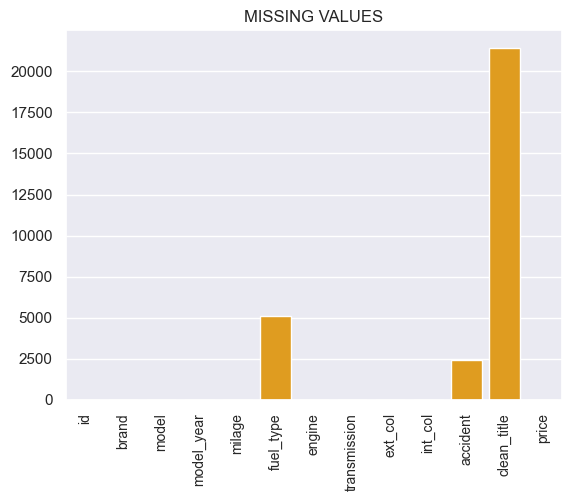

In [90]:
def plot_missing_vals(dataset):
    col_names = dataset.columns
    dict_n = dict()

    # Loop over each feature and add the column name as key and missing values count as value
    for feature in col_names:
        dict_n[feature] = dataset[feature].isna().sum()

    sns.barplot(dict_n, color='orange')
    plt.xticks(fontsize=10, rotation=90)
    plt.title("MISSING VALUES")

# Example usage with a dataset
plot_missing_vals(dataset)


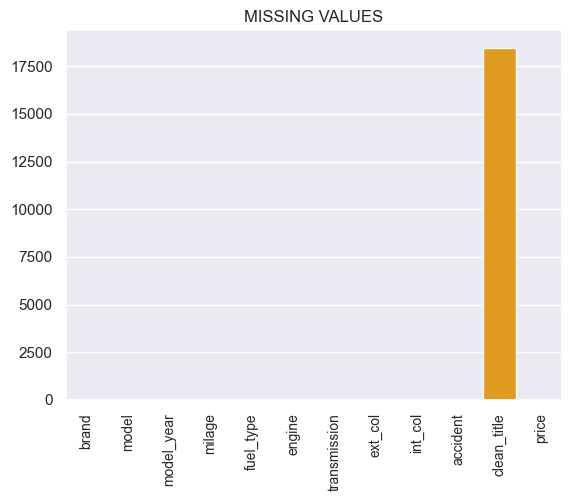

In [91]:
# DROPPING MISSING VALUES IN fuel_type & accident
dataset.drop(['id'], axis=1, inplace=True)
dataset.dropna(subset=['fuel_type', 'accident'], inplace=True)
plot_missing_vals(dataset)

In [92]:
# IMPUTATION OF MISSING VALUES
# Replacing missing categorical features with the most frequent data

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

cat_imputer = SimpleImputer(strategy='most_frequent')

def data_imputer(data):
    imputer = ColumnTransformer([
        ('cat', cat_imputer, ['clean_title'])
    ], remainder='passthrough')
    dat = imputer.fit_transform(dataset)
    return pd.DataFrame(dat, columns=['clean_title', 'brand', 'model', 'model_year', 'milage', 'fuel_type','engine','transmission', 'ext_col', 'int_col', 'accident', 'price'])

imputed_data = data_imputer(dataset)

## Handling Outliers

In [93]:
import pandas as pd

def outliers_remover(dataset, features):
    # An empty DataFrame to store outliers
    outliers = pd.DataFrame()

    for feature in features:
        Q1 = dataset[feature].quantile(0.25)
        Q3 = dataset[feature].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_instances = dataset[(dataset[feature] < lower_bound) | (dataset[feature] > upper_bound)]

        outliers = pd.concat([outliers, outliers_instances]).drop_duplicates()

        print(f"FEATURE: {feature}, NUM OF OUTLIERS: {len(outliers_instances)}")

    clean_dataset = dataset.drop(outliers.index)
    print(f"TOTAL OUTLIERS REMOVED: {len(outliers)}")

    return clean_dataset



In [94]:
clean = outliers_remover(imputed_data, ['milage', 'price', 'model_year'])

FEATURE: milage, NUM OF OUTLIERS: 1742
FEATURE: price, NUM OF OUTLIERS: 11071
FEATURE: model_year, NUM OF OUTLIERS: 5069
TOTAL OUTLIERS REMOVED: 17426


In [95]:
from sklearn.ensemble import IsolationForest

# DETECTING OUTLIERS USING ISOLATION FORESTS
def detect_outliers_isolation_forest(data, features):
    iso_forest = IsolationForest(contamination=0.19, random_state=42)
    predictions = iso_forest.fit_predict(data[features])

    # Outliers are marked as -1
    outliers = data[predictions == -1]

    return outliers

clean = clean.drop(detect_outliers_isolation_forest(clean, ['milage', 'price', 'model_year']).index)

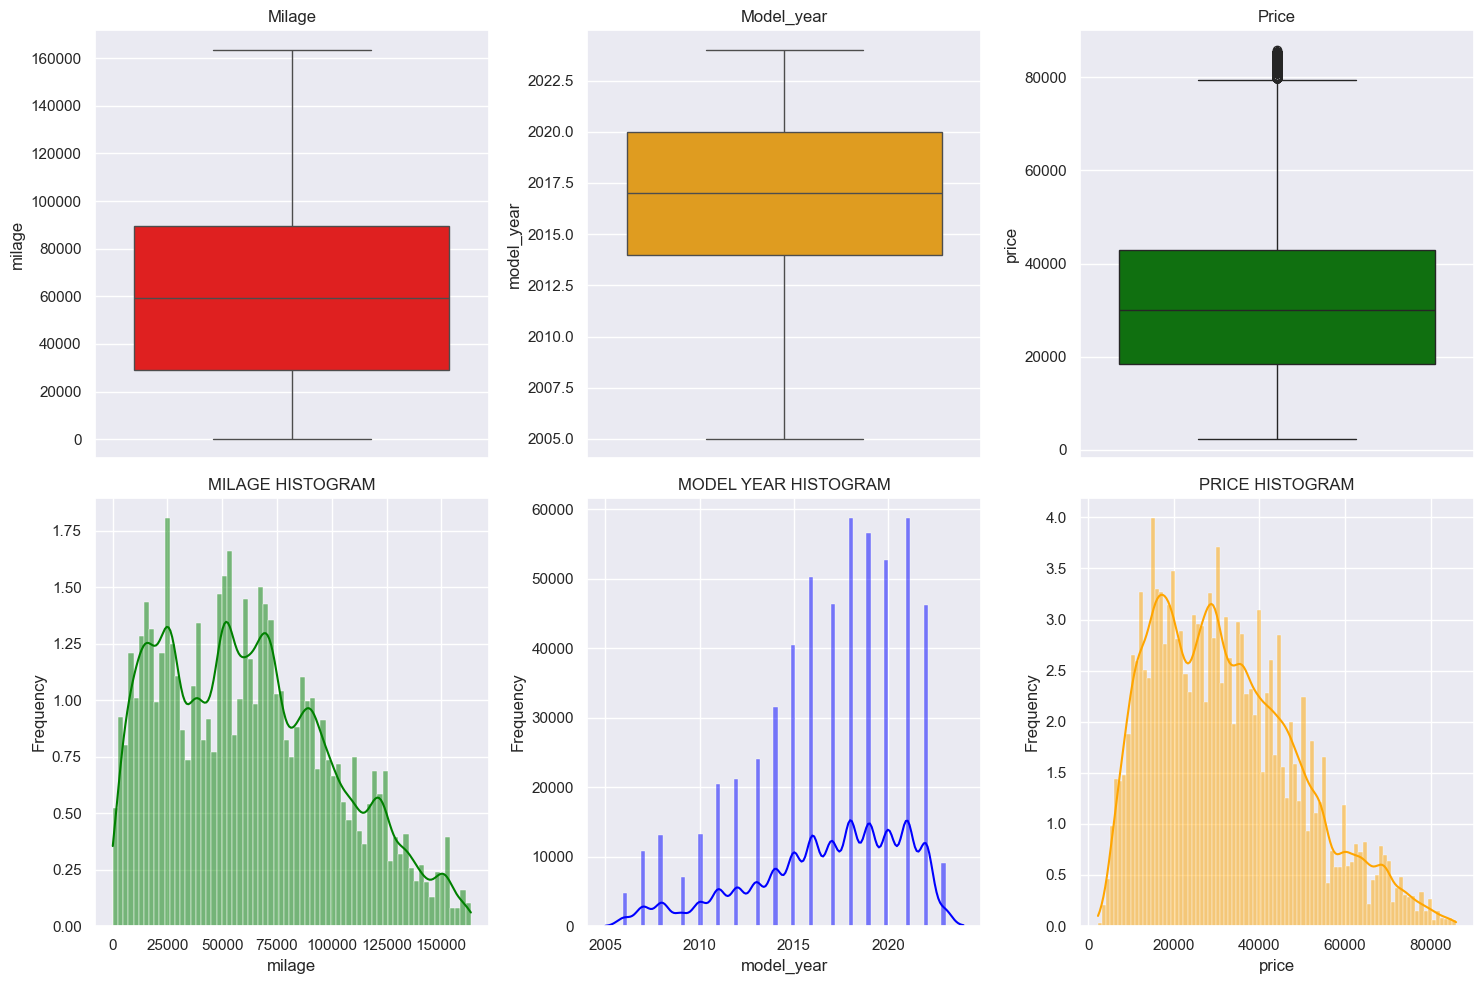

In [96]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.boxplot(clean['milage'], color='red', ax=axes[0,0])
axes[0,0].set_title('Milage')
sns.boxplot(clean['model_year'], color='orange', ax=axes[0,1])
axes[0,1].set_title('Model_year')
sns.boxplot(clean['price'], color='green', ax=axes[0,2])
axes[0,2].set_title('Price')


sns.histplot(data=clean['milage'], stat='frequency', kde=True, color='green', ax=axes[1,0])
axes[1,0].set_title('MILAGE HISTOGRAM')
sns.histplot(data=clean['model_year'], stat='frequency', kde=True, color='blue', ax=axes[1,1])
axes[1,1].set_title('MODEL YEAR HISTOGRAM')
sns.histplot(data=clean['price'], stat='frequency', kde=True, color='orange', ax=axes[1,2])
axes[1,2].set_title('PRICE HISTOGRAM')

plt.plot()
plt.tight_layout()


## Removing Weird Symbols

In [142]:
# Removing weird symbols from the dataset
df_clean = clean[~clean.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]

C:\Users\deusm\AppData\Local\Temp\ipykernel_4940\2766601666.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_clean = clean[~clean.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]


In [145]:
# Saving Cleaned Train Data
df_clean.to_csv("../datasets/cleaned_train_data/train_data.csv", index=False)